In [41]:
import sklearn
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.filterwarnings('ignore')

In [42]:
conn = sqlite3.connect('../db.sqlite3')

In [43]:
df_raw = pd.read_sql_query("SELECT * FROM scraper_auto", conn).dropna()

In [44]:
df_raw.head()

,id,kenteken,bouwjaar,kilometer_stand,vermogen,isHandgeschakeld,isBenzine,prijs,url,titel,upload_datum
1,24,96-GZR-3,2008,117910.0,77.0,0,1,3750.0,https://www.marktplaats.nl/a/auto-s/fiat/m1554...,Fiat Grande Punto 1.4 Edizione Lusso AUTOMAAT!,2020-05-23 15:01:00
2,25,,2008,119486.0,75.0,1,1,3950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1555...,Fiat Grande Punto 1.4 Dynamic 5 DEURS AIRCO,2020-05-25 12:10:00
3,26,90-ZJ-ZN,2008,169504.0,78.0,0,1,2950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1556...,Fiat Grande Punto 1.4-16V Emotion 5dr Automaat...,2020-05-27 13:22:00
4,27,34-HZP-4,2009,211763.0,78.0,1,1,2495.0,https://www.marktplaats.nl/a/auto-s/fiat/m1546...,Fiat Grande Punto 1.4 NeroBianco 2009 | APK to...,2020-05-05 16:31:00
5,28,03-TL-VK,2006,107414.0,65.0,1,1,2195.0,https://www.marktplaats.nl/a/auto-s/fiat/m1557...,"Fiat Grande Punto 1.2 Sportsound AIRCO, NAP NE...",2020-05-30 17:13:00


In [52]:
target_names = ["bouwjaar", "kilometer_stand", "vermogen", "prijs", "isHandgeschakeld", "isBenzine", "upload_datum"]

df = df_raw[target_names]
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df.describe()

,bouwjaar,kilometer_stand,vermogen,prijs,isHandgeschakeld,isBenzine
count,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000
mean,2008.299503,177303.811102,85.538525,2780.887738,0.994615,0.673157
std,1.878672,63730.292104,20.834058,1078.379585,0.073202,0.469157
min,2005.000000,15570.000000,51.000000,1.000000,0.000000,0.000000
25%,2007.000000,145200.000000,78.000000,2250.000000,1.000000,0.000000
50%,2008.000000,179000.000000,78.000000,2750.000000,1.000000,1.000000
75%,2010.000000,205258.000000,86.000000,3250.000000,1.000000,1.000000
max,2014.000000,368661.000000,180.000000,6950.000000,1.000000,1.000000


In [53]:
df_train = df_train[(df_train['prijs'] > 2000.) & (df_train['prijs'] < 8000.)]
df_test = df_test[(df_test['prijs'] > 2000.) & (df_test['prijs'] < 8000.)]

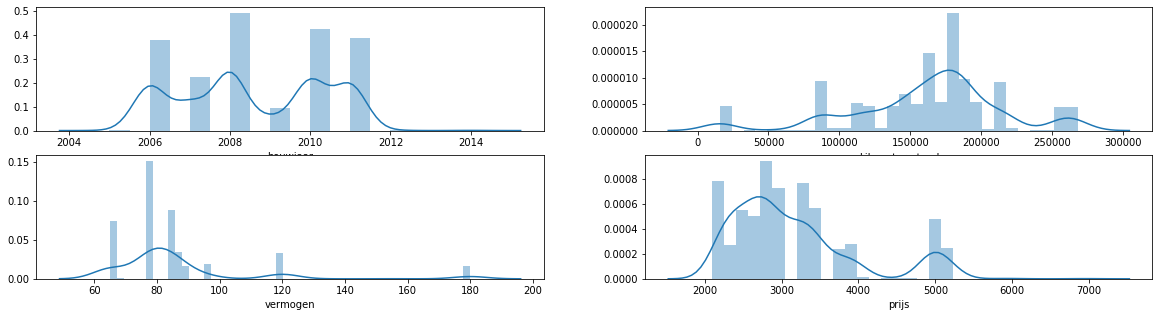

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(20,5))

sns.distplot(df_train['bouwjaar'], ax=axs[0][0]);
sns.distplot(df_train['kilometer_stand'], ax=axs[0][1]);
sns.distplot(df_train['vermogen'], ax=axs[1][0]);
sns.distplot(df_train['prijs'], ax=axs[1][1]);

In [50]:
df_train['timestamp'] = pd.to_datetime(df_train['upload_datum'])
df_train['timestamp'] = df_train['timestamp'].map(datetime.toordinal)

df_test['timestamp'] = pd.to_datetime(df_test['upload_datum'])
df_test['timestamp'] = df_test['timestamp'].map(datetime.toordinal)

df_train = df_train.drop('upload_datum', axis=1).dropna()
df_test = df_test.drop('upload_datum', axis=1).dropna()

In [51]:
df_train.to_pickle("./train_data.pkl")
df_test.to_pickle("./test_data.pkl")